## Summary

----

## Imports

In [1]:
import os
import socket
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline

pd.set_option("max_columns", 100)

## Parameters

In [3]:
NOTEBOOK_PATH = Path(os.getenv("CI_JOB_NAME", "01_pdb_cbeta_stats"))

NOTEBOOK_PATH

PosixPath('01_pdb_cbeta_stats')

In [4]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

OUTPUT_PATH

PosixPath('/kimlab2/database_data/datapkg/pdb-analysis/notebooks/01_pdb_cbeta_stats')

In [5]:
if "scinet" in socket.gethostname():
    CPU_COUNT = 40
else:
    CPU_COUNT = max(1, len(os.sched_getaffinity(0)) // 2)

CPU_COUNT

12

In [6]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [7]:
DEBUG = TASK_ID is None

if DEBUG:
    TASK_ID = 1
    TASK_COUNT = 300
else:
    assert TASK_ID is not None
    assert TASK_COUNT is not None

TASK_ID, TASK_COUNT

(1, 300)

In [8]:
PDB_ANALYSIS_DATA_PATH = (
    Path(os.getenv("DATAPKG_OUTPUT_DIR")).joinpath("pdb-analysis", "v0.4").resolve(strict=True)
)

PDB_ANALYSIS_DATA_PATH

PosixPath('/kimlab2/database_data/databin/pdb-analysis/v0.4')

## Load statistics data

In [9]:
output_dir = PDB_ANALYSIS_DATA_PATH.joinpath("pdb-cbeta-stats")

print(output_dir)

/kimlab2/database_data/databin/pdb-analysis/v0.4/pdb-cbeta-stats


In [10]:
data = []
for task_id in tqdm(range(1, TASK_COUNT + 1)):
    output_file = output_dir.joinpath(f"pdb-cbeta-stats-{task_id}-{TASK_COUNT}.torch")
    if not output_file.with_suffix(".SUCCESS").is_file():
        print(task_id, output_file)
        continue
    with output_file.open("rb") as fin:
        num_rows_read = 0
        while True:
            try:
                row = torch.load(fin)
                num_rows_read += 1
            except EOFError:
                if num_rows_read < 500:
                    print(task_id, num_rows_read, output_file)
#                     raise
                break
            else:
                data.append(row)

300 /kimlab2/database_data/databin/pdb-analysis/v0.4/pdb-cbeta-stats/pdb-cbeta-stats-300-300.torch



## Create validation plots

In [11]:
cb_residues = np.vstack([row[2] for row in data if row[2] is not None and row[3] is not None])
cb_vectors = np.vstack([row[3] for row in data if row[2] is not None and row[3] is not None])

In [12]:
cb_vectors_ala = cb_vectors[cb_residues.reshape(-1) == "ALA", :]

0.9357068986630099 0.027465371535687625
-1.1999374252852002 0.020877555051197268
-0.0300870890760455 0.0117160484381385


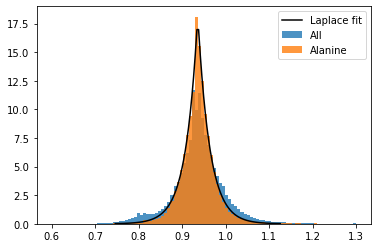

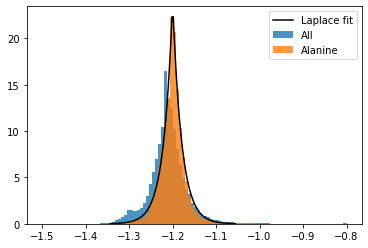

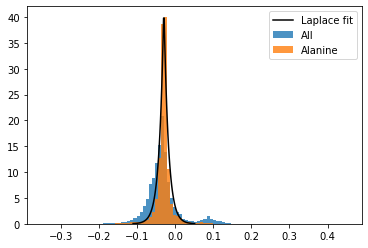

In [13]:
for i, xlim in [(0, (0.6, 1.3)), (1, (-1.5, -0.8)), (2, (-0.35, 0.45))]:
    fg, ax = plt.subplots()
    ax.hist(np.clip(cb_vectors[:, i], *xlim), bins=100, density=True, alpha=0.8, label="All")
    ax.hist(
        np.clip(cb_vectors_ala[:, i], *xlim), bins=100, density=True, alpha=0.8, label="Alanine"
    )

    #     median = np.percentile(cb_vectors[:, i], np.array([50])).item()
    #     std = np.std(cb_vectors[:, i])
    #     ax.vlines(median, *ax.get_ylim(), linestyle=":", label=f"All median")

    loc, scale = stats.laplace.fit(cb_vectors_ala[:, i])
    rv = stats.laplace(loc, scale)
    x = np.linspace(*rv.interval(0.999), 100)
    y = rv.pdf(x)
    plt.plot(x, y, "k-", label="Laplace fit")

    ax.legend()
    print(loc, scale)